In [3]:
import math
import numpy as np
import torch
import gpytorch
from gpytorch.kernels import GridInterpolationKernel as SKI
from gpytorch.kernels import SpectralMixtureKernel as SM
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from matplotlib import pyplot as plt
import matplotlib.image as img
from tqdm import tqdm
from gp import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

# No interpolation

In [4]:
class GPModel(gpytorch.models.ExactGP):
    """
    A GP Model that performs exact gp inference
    :param train_x: torch.tensor
    :param train_y: torch.tensor
    :param likelihood: torch.tensor
    """
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SKI(
            ScaleKernel(
                RBFKernel(ard_num_dims=2)
            ), grid_size=grid_size, num_dims=2 
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(model, likelihood, optimizer, training_iter:int, train_x: torch.tensor, train_y:torch.tensor):
    """ 
    Find optimal model hyperparameters
    """
    model.train()
    likelihood.train()

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}")
        optimizer.step()

def test(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(test_x))
    return observed_pred

def plot_img(img, *args, **kwargs):
    """
    plot an image without axis
    """
    plt.axis("off")
    plt.imshow(img, *args, **kwargs)
    plt.show()

In [24]:
def prep_training_img(path: str, first_coord_crop:tuple, second_coord_crop:tuple) -> (torch.tensor, 
        torch.tensor, torch.tensor):
    """
    prepare the training image by occlude a patch of it
    :param path: path to the test image
    :param first_coord_crop: (start, end) the start and end of the first coordinate of the cropping area
    :param second_coord_crop: ... second coordinate ...
    : return : (1) train_x
               (2) train_y
               (3) test_x
               (4) occulated image
    """
    # prepare the training image
    training_img = img.imread(path)
    print(training_img.shape)

    training_img = training_img[::4,::4,:]
    print(training_img.shape)
    plot_img(training_img)
    plot_img(training_img[:,:,0], cmap=plt.cm.Reds_r)
    plot_img(training_img[:,:,1], cmap=plt.cm.Greens_r)
    plot_img(training_img[:,:,2], cmap=plt.cm.Blues_r)
    
    # occlude the original image
    crop_fs, crop_fe = first_coord_crop
    crop_ss, crop_se = second_coord_crop
    training_img[crop_fs:crop_fe, crop_ss:crop_se, :] = 0.99999
    plot_img(training_img)
    plot_img(training_img[:,:,0], cmap=plt.cm.Reds_r)
    plot_img(training_img[:,:,1], cmap=plt.cm.Greens_r)
    plot_img(training_img[:,:,2], cmap=plt.cm.Blues_r)
    
    # we store the x-coordinate in row-major order
    # train_x
    first_coord_cap, second_coord_cap, _ = training_img.shape
    train_x_first_coord = np.concatenate((
        np.repeat(np.arange(crop_fs), second_coord_cap),
        np.repeat(np.arange(crop_fs, crop_fe), second_coord_cap - (crop_se - crop_ss)),
        np.repeat(np.arange(crop_fe, first_coord_cap), second_coord_cap)
    ))
    train_x_second_coord = np.concatenate((
        np.tile(np.arange(second_coord_cap), crop_fs),
        np.tile(np.concatenate((np.arange(crop_ss),np.arange(crop_se,second_coord_cap))), crop_fe - crop_fs),
        np.tile(np.arange(second_coord_cap), first_coord_cap - crop_fe)
    ))
    train_x = np.stack((train_x_first_coord, train_x_second_coord)).T

    # train_y_rgb
    train_y_rgb = (training_img[train_x[:, 0], train_x[:, 1], 0], 
                   training_img[train_x[:, 0], train_x[:, 1], 1],
                   training_img[train_x[:, 0], train_x[:, 1], 2])

    # test_x
    test_x = np.meshgrid(np.arange(crop_fs, crop_fe), np.arange(crop_ss, crop_se))
    test_x = np.stack((test_x[0].T.ravel(), test_x[1].T.ravel())).T

    # convert x to float, and all to tensor
    train_y_rgb = list(map(lambda x: torch.tensor(x).float(), train_y_rgb))
    train_x = torch.tensor(train_x).float()
    test_x = torch.tensor(test_x).float()
    return train_x, train_y_rgb, test_x, training_img

(502, 921, 4)
(126, 231, 4)


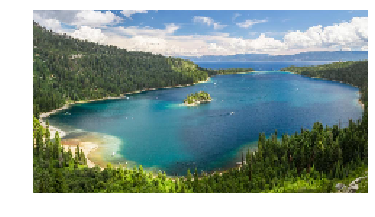

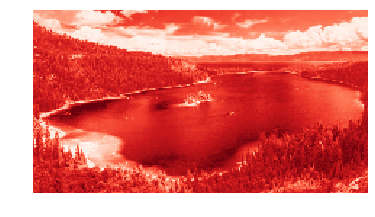

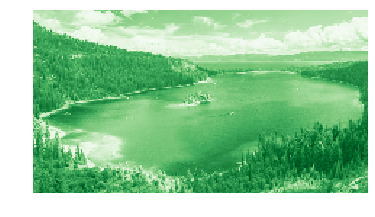

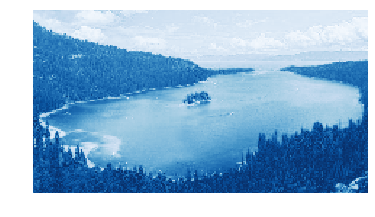

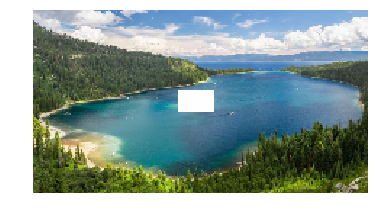

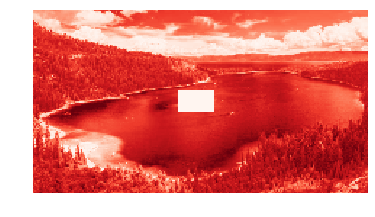

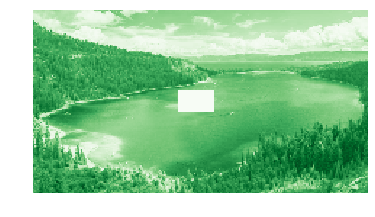

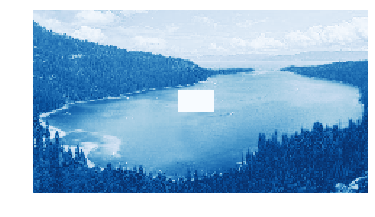

In [26]:
path="images/sample_img.png"

crop_fs, crop_fe = 55, 70
crop_ss, crop_se = 100, 125
patch_shape = (crop_fe - crop_fs, crop_se - crop_ss)
train_x, train_y_rgb, test_x, occluded = prep_training_img_ir(path, (crop_fs, crop_fe), (crop_ss, crop_se))

In [11]:
train_y_rgb[0].shape

torch.Size([28731])

In [22]:
# Train: initialize likelihood and model
likelihood_r, likelihood_g, likelihood_b = GaussianLikelihood(), GaussianLikelihood(), GaussianLikelihood()
model_r = GPModel(train_x, train_y_rgb[0], likelihood_r)
model_g = GPModel(train_x, train_y_rgb[1], likelihood_g)
model_b = GPModel(train_x, train_y_rgb[2], likelihood_b)
optimizer_r = torch.optim.Adam([{"params":model_r.parameters()}], lr=0.1)
optimizer_g = torch.optim.Adam([{"params":model_g.parameters()}], lr=0.1)
optimizer_b = torch.optim.Adam([{"params":model_b.parameters()}], lr=0.1)
train(model_r, likelihood_r, optimizer_r, 60, train_x, train_y_rgb[0])
train(model_g, likelihood_g, optimizer_g, 60, train_x, train_y_rgb[1])
train(model_b, likelihood_b, optimizer_b, 60, train_x, train_y_rgb[2])

Iter 1/60 - Loss: 0.966
Iter 2/60 - Loss: 0.905
Iter 3/60 - Loss: 0.847
Iter 4/60 - Loss: 0.795
Iter 5/60 - Loss: 0.743
Iter 6/60 - Loss: 0.697
Iter 7/60 - Loss: 0.653
Iter 8/60 - Loss: 0.608
Iter 9/60 - Loss: 0.562
Iter 10/60 - Loss: 0.513
Iter 11/60 - Loss: 0.463
Iter 12/60 - Loss: 0.411
Iter 13/60 - Loss: 0.360
Iter 14/60 - Loss: 0.310
Iter 15/60 - Loss: 0.262
Iter 16/60 - Loss: 0.215
Iter 17/60 - Loss: 0.168
Iter 18/60 - Loss: 0.120
Iter 19/60 - Loss: 0.072
Iter 20/60 - Loss: 0.021
Iter 21/60 - Loss: -0.029
Iter 22/60 - Loss: -0.078
Iter 23/60 - Loss: -0.126
Iter 24/60 - Loss: -0.174
Iter 25/60 - Loss: -0.222
Iter 26/60 - Loss: -0.270
Iter 27/60 - Loss: -0.320
Iter 28/60 - Loss: -0.368
Iter 29/60 - Loss: -0.418
Iter 30/60 - Loss: -0.465
Iter 31/60 - Loss: -0.512
Iter 32/60 - Loss: -0.558
Iter 33/60 - Loss: -0.604
Iter 34/60 - Loss: -0.650
Iter 35/60 - Loss: -0.695
Iter 36/60 - Loss: -0.738
Iter 37/60 - Loss: -0.780
Iter 38/60 - Loss: -0.821
Iter 39/60 - Loss: -0.860
Iter 40/60 - Lo

In [25]:
# Test: prediction on the test set
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    pred_r = test(model_r, likelihood_r, test_x).mean.view(patch_shape).numpy()
    pred_g = test(model_g, likelihood_g, test_x).mean.view(patch_shape).numpy()
    pred_b = test(model_g, likelihood_g, test_x).mean.view(patch_shape).numpy()

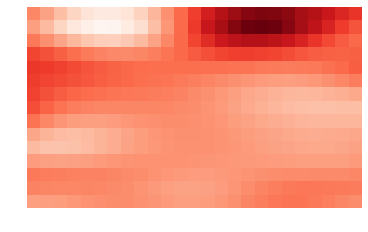

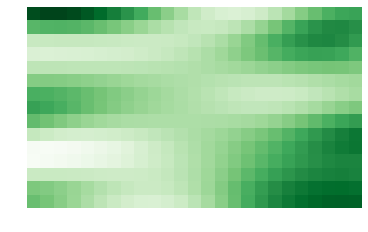

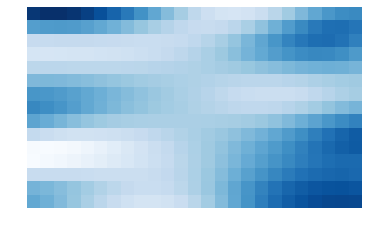

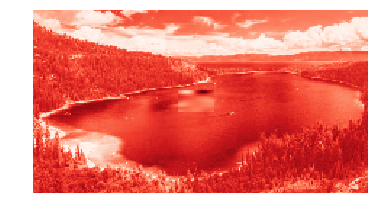

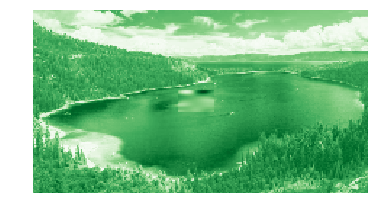

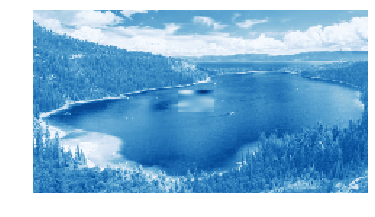

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


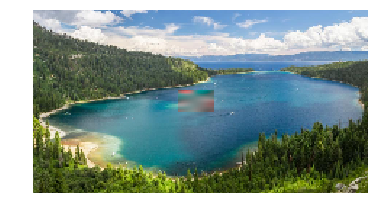

In [45]:
# plot the reconstructed patch
plot_img(pred_r, cmap=plt.cm.Reds_r)
plot_img(pred_g, cmap=plt.cm.Greens_r)
plot_img(pred_b, cmap=plt.cm.Blues_r)

# plot the whole image
occluded[crop_fs:crop_fe, crop_ss:crop_se, 0] = pred_r
occluded[crop_fs:crop_fe, crop_ss:crop_se, 1] = pred_g
occluded[crop_fs:crop_fe, crop_ss:crop_se, 2] = pred_b
plot_img(occluded[..., 0], cmap=plt.cm.Reds_r)
plot_img(occluded[..., 0], cmap=plt.cm.Greens_r)
plot_img(occluded[..., 0], cmap=plt.cm.Blues_r)
plot_img(occluded)